<a href="https://colab.research.google.com/github/gongx030/dream_PGE/blob/main/prepare_tfdatasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare a tfdataset object on the full data

This notebook runs on MSI

### Install external packages

In [ ]:
!pip install tensorflow==2.6 keras==2.6
!pip install tensorflow-addons==0.14.0
!pip install tensorflow_probability==0.14.1
!pip install session_info
!pip install biopython
!pip install sklearn
!pip install matplotlib

## Load Python packages

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_addons as tfa
from scipy import stats
import session_info
import tensorflow_probability as tfp
import pdb
from sklearn.metrics import r2_score
import shutil
import pandas as pd
import re
import os
from Bio.Seq import Seq
import gc
import matplotlib.pyplot as plt
import datetime

## Parameters

In [ ]:
ARGS = {
  'max_width' : 100,
  'pct_ds' : 1, # % of total data for training/testing
  'alphabets' : {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3, 'N' : 4, 'M' : 5},
  'missing_letter' : 'N',
  'mask_letter' : 'M',
  'max_expression_value' : 17,
  'head_len' : 17,
  'tail_len' : 13,
}
ARGS['remote_data_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/training_data/pct_ds=' + str(ARGS['pct_ds']) + '/'
ARGS['local_data_dir'] = re.sub('https://', './', ARGS['remote_data_dir'])

## Prepare data

In [ ]:
remote_train_file ='https://s3.msi.umn.edu/gongx030/projects/dream_PGE/train_sequences.txt.gz'
local_train_file = re.sub('https://', './', remote_train_file)
os.system('wget -cx ' + remote_train_file)

--2022-07-15 09:19:04--  https://s3.msi.umn.edu/gongx030/projects/dream_PGE/train_sequences.txt.gz
Resolving s3.msi.umn.edu (s3.msi.umn.edu)... 128.101.189.144
Connecting to s3.msi.umn.edu (s3.msi.umn.edu)|128.101.189.144|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



0

In [ ]:
df = pd.read_csv(local_train_file, compression = 'gzip', sep = '\t', header = None)
df.columns = ['dna', 'expression']
df['dna'] = df['dna'].astype('string')

In [ ]:
n = int(len(df) * ARGS['pct_ds'])
print('downsampled dataset size: %d' % (n))

downsampled dataset size: 6739258


In [ ]:
df = df.sample(n = n, random_state = 1)

In [ ]:
df['len'] = df['dna'].str.len()

min len: 78
max len: 142


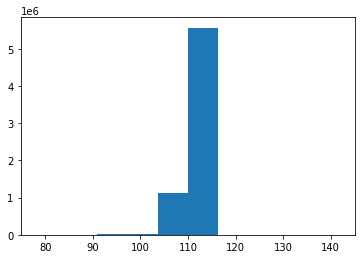

In [ ]:
plt.hist(df['len'])
print('min len: {}'.format(df['len'].min()))
print('max len: {}'.format(df['len'].max()))

In [ ]:
print('number of unique sequences in the first {} positions: {}'.format(ARGS['head_len'], len(df['dna'].str[:ARGS['head_len']].unique())))

number of unique sequences in the first 17 positions: 1


In [ ]:
print('number of unique sequences in the last {} positions: {}'.format(ARGS['tail_len'], len(df['dna'].str[-ARGS['tail_len']:].unique())))

number of unique sequences in the last 13 positions: 1


In [ ]:
df['dna'] = df['dna'].str[ARGS['head_len']:]
df['dna'] = df['dna'].str[:-ARGS['tail_len']]

min len: 48
max len: 112


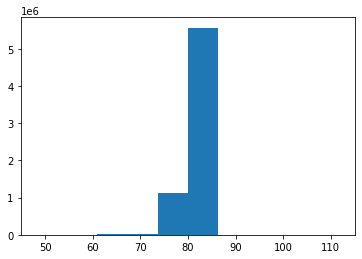

In [ ]:
df['len'] = df['dna'].str.len()
plt.hist(df['len'])
print('min len: {}'.format(df['len'].min()))
print('max len: {}'.format(df['len'].max()))

In [ ]:
print('removing {} samples which length is greater than {}'.format(len(df[df['len'] > ARGS['max_width']]), ARGS['max_width']))

removing 1690 samples which length is greater than 100


In [ ]:
df = df[df['len'] <= ARGS['max_width']]

In [ ]:
print('dataset size: %d' % (len(df)))

dataset size: 6737568


In [ ]:
df['dna'] = df['dna'].str.pad(width = ARGS['max_width'], side = 'both', fillchar = 'N')
df['dna'] = df['dna'] + df['dna'].apply(lambda x: str(Seq(x).reverse_complement())).astype('string')

In [ ]:
n_positions = int(ARGS['max_width'] * 2)
print('# positions=%d' % (n_positions))

# positions=200


In [ ]:
#dna = df['dna'].apply(list) # this will eat up all memory even on the high mem instance
dna = np.empty((0, n_positions), np.uint8)
for x in np.array_split(df['dna'], 10): # split data into chunks
  y = np.array(x.apply(list))
  y = np.vstack(y)
  y = np.vectorize(ARGS['alphabets'].get)(y)
  y = y.astype(np.uint8)
  print(y.shape)
  dna = np.append(dna, y, axis = 0)

(673757, 200)
(673757, 200)
(673757, 200)
(673757, 200)
(673757, 200)
(673757, 200)
(673757, 200)
(673757, 200)
(673756, 200)
(673756, 200)


In [ ]:
input_dim = int(5) # A,C,G,T,N

In [ ]:
expression = df['expression'].to_numpy()
expression_std = np.std(expression)
expression_mean = np.mean(expression)
expression = (expression - expression_mean) / expression_std
expression = tf.cast(expression, tf.float32)

2022-07-15 09:31:05.843425: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-15 09:31:07.862011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37711 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:06:00.0, compute capability: 8.0
2022-07-15 09:31:07.863555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37711 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2022-07-15 09:31:07.864972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/devi

In [ ]:
base = np.zeros(dna.shape, dtype = np.uint8)
base[dna == 4] = 0 #
base[(dna == 0) | (dna == 2)] = 1 # A/G
base[(dna == 1) | (dna == 3)] = 2 # C/T

In [ ]:
ds = tf.data.Dataset.from_tensor_slices({
    'seq' : dna,
    'expression' : expression,
    'base' : base,
})

In [ ]:
print('writing data to {}'.format(ARGS['local_data_dir']))
tf.data.experimental.save(ds, ARGS['local_data_dir'])

writing data to ./s3.msi.umn.edu/gongx030/projects/dream_PGE/training_data/pct_ds=1/


2022-07-15 09:31:21.810099: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Note that to load a previously saved dataset, you need to specify element_spec -- a type signature of the elements of the saved dataset, which can be obtained via tf.data.Dataset.element_spec. This requirement exists so that shape inference of the loaded dataset does not need to perform I/O.

In [ ]:
ds.element_spec

{'seq': TensorSpec(shape=(200,), dtype=tf.uint8, name=None),
 'expression': TensorSpec(shape=(), dtype=tf.float32, name=None),
 'base': TensorSpec(shape=(200,), dtype=tf.uint8, name=None)}

# SessionInfo

In [ ]:
session_info.show()